<a href="https://colab.research.google.com/github/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/2_downstream_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will demonstrate how `gget` can assist downstream analysis of single-cell RNA sequencing data. We will use the single-cell transcriptome of the retinal fovea of a 2-year old macaque published in [Yi, et al. 2021](https://academic.oup.com/nsr/article/8/4/nwaa179/5896967) as an example dataset.  

[Link to data preprocessing notebook](https://github.com/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/1_align_quality-control_cluster.ipynb)  
[Raw data link](https://ngdc.cncb.ac.cn/gsa/browse/CRA002680/CRR138429)

___

Install `gget` from dev branch of the repository (only necessary until next release):

In [ ]:
!git clone -b dev --single-branch https://github.com/lauraluebbert/gget.git -q
!pip install mysql-connector-python -q
!cd gget && pip install . -q

     |████████████████████████████████| 37.6 MB 1.3 MB/s 
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 128 kB 5.1 MB/s 


Install and import packages:

In [ ]:
!pip install anndata scanpy==1.7.2 matplotlib==3.1.3 leidenalg -q
%config InlineBackend.figure_format = 'retina'

import gget

import anndata
import numpy as np
import pandas as pd

# Change the directory to the scRNAseq_workflow folder for ease
import os
os.chdir("/content/gget/examples/scRNAseq_workflow")

# Import custom plotting functions
import funcs

     |████████████████████████████████| 96 kB 2.5 MB/s 
     |████████████████████████████████| 10.3 MB 35.2 MB/s 
     |████████████████████████████████| 13.1 MB 33.8 MB/s 
     |████████████████████████████████| 1.3 MB 41.6 MB/s 
     |████████████████████████████████| 88 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 
     |████████████████████████████████| 3.1 MB 35.7 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


25 Apr 2022 18:22:01 INFO NumExpr defaulting to 2 threads.


___

Load the [pre-processed data](https://github.com/lauraluebbert/gget/blob/dev/examples/scRNAseq_workflow/1_align_quality-control_cluster.ipynb):

In [ ]:
# Concatenate the split files in the data folder into a single h5ad file
!cd data/ && cat xaa xab xac > macaque_preprocessed.h5ad

In [ ]:
adata = anndata.read_h5ad("data/macaque_preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 9991 × 35432
    obs: 'n_counts_processed', 'leiden'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

___

# Celltype assignment based on known marker genes

We will define a dictionary containing the expected celltypes and their respective marker genes (reference: [Supplementary Table 2](https://academic.oup.com/nsr/article/8/4/nwaa179/5896967?login=true#supplementary-data)). For ease and speed, we are only defining one marker per celltye.

In [ ]:
marker_gene_dict = {
    "amacrine cells": "ATP1B1",
    "astrocytes": "GFAP",
    "bipolar cells": "PCP2",
    "cones": "ARR3",
    "ganglion cells": "SNCG",
    "horizontal cells": "PVALB",
    "Müller glia": "FRZB",
    "microglia": "CD74",
    "endothelial cells/ pericytes": "IGFBP7",
    "rods": "rhodopsin",
}

# `gget.search` to find the Ensembl IDs of the known marker genes:

In [ ]:
ens_marker_genes = gget.search(list(marker_gene_dict.values()), "macaca_m")
# Custom function to wrap columns for easier reading in Colab
funcs.pretty_print(ens_marker_genes, ["ensembl_description", "ext_ref_description", "url"])

25 Apr 2022 18:22:06 INFO Fetching results from database: macaca_mulatta_core_106_10
25 Apr 2022 18:22:11 INFO Query time: 5.93 seconds
25 Apr 2022 18:22:11 INFO Matches found: 11


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url
0,ENSMMUG00000021078,ATP1B1,ATPase Na+/K+ transportingsubunit beta 1 [Source:VGNCSymbol;Acc:VGNC:70176],ATPase Na+/K+ transportingsubunit beta 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000021078
1,ENSMMUG00000013115,GFAP,glial fibrillary acidicprotein [Source:VGNCSymbol;Acc:VGNC:72913],glial fibrillary acidicprotein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000013115
2,ENSMMUG00000060224,PCP2,Purkinje cell protein 2[Source:VGNCSymbol;Acc:VGNC:75706],Purkinje cell protein 2,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000060224
3,ENSMMUG00000013935,ARR3,arrestin 3 [Source:VGNCSymbol;Acc:VGNC:70020],arrestin 3,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000013935
4,ENSMMUG00000011849,SNCG,synuclein gamma [Source:VGNCSymbol;Acc:VGNC:77671],synuclein gamma,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000011849
5,ENSMMUG00000008778,PVALB,parvalbumin [Source:VGNCSymbol;Acc:VGNC:76627],parvalbumin,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000008778
6,ENSMMUG00000014396,FRZB,frizzled related protein[Source:VGNCSymbol;Acc:VGNC:72819],frizzled related protein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000014396
7,ENSMMUG00000009113,CD74,CD74 molecule [Source:VGNCSymbol;Acc:VGNC:70779],CD74 molecule,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000009113
8,ENSMMUG00000014011,IGFBP7,insulin like growth factorbinding protein 7 [Source:VGNCSymbol;Acc:VGNC:73578],insulin like growth factorbinding protein 7,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000014011
9,ENSMMUG00000021223,RRH,retinal pigment epithelium-derived rhodopsin homolog[Source:VGNCSymbol;Acc:VGNC:76940],retinal pigment epithelium-derived rhodopsin homolog,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene/Summary?g=ENSMMUG00000021223


Let's find these Ensembl IDs in our dataset index. **This approach has the advantage that even genes not annotated with their gene name in the reference genome can be found.**

In [ ]:
marker_genes = funcs.find_ids(adata, ens_marker_genes["ensembl_id"].values)
marker_genes

['ATP1B1_ENSMMUG00000021078.4',
 'GFAP_ENSMMUG00000013115.4',
 'PCP2_ENSMMUG00000060224.1',
 'ARR3_ENSMMUG00000013935.4',
 'SNCG_ENSMMUG00000011849.4',
 'PVALB_ENSMMUG00000008778.4',
 'FRZB_ENSMMUG00000014396.4',
 'CD74_ENSMMUG00000009113.4',
 'IGFBP7_ENSMMUG00000014011.4',
 'RRH_ENSMMUG00000021223.4',
 'RHO_ENSMMUG00000055315.1']

Let's rank the marker genes per cluster for the celltype assignment:

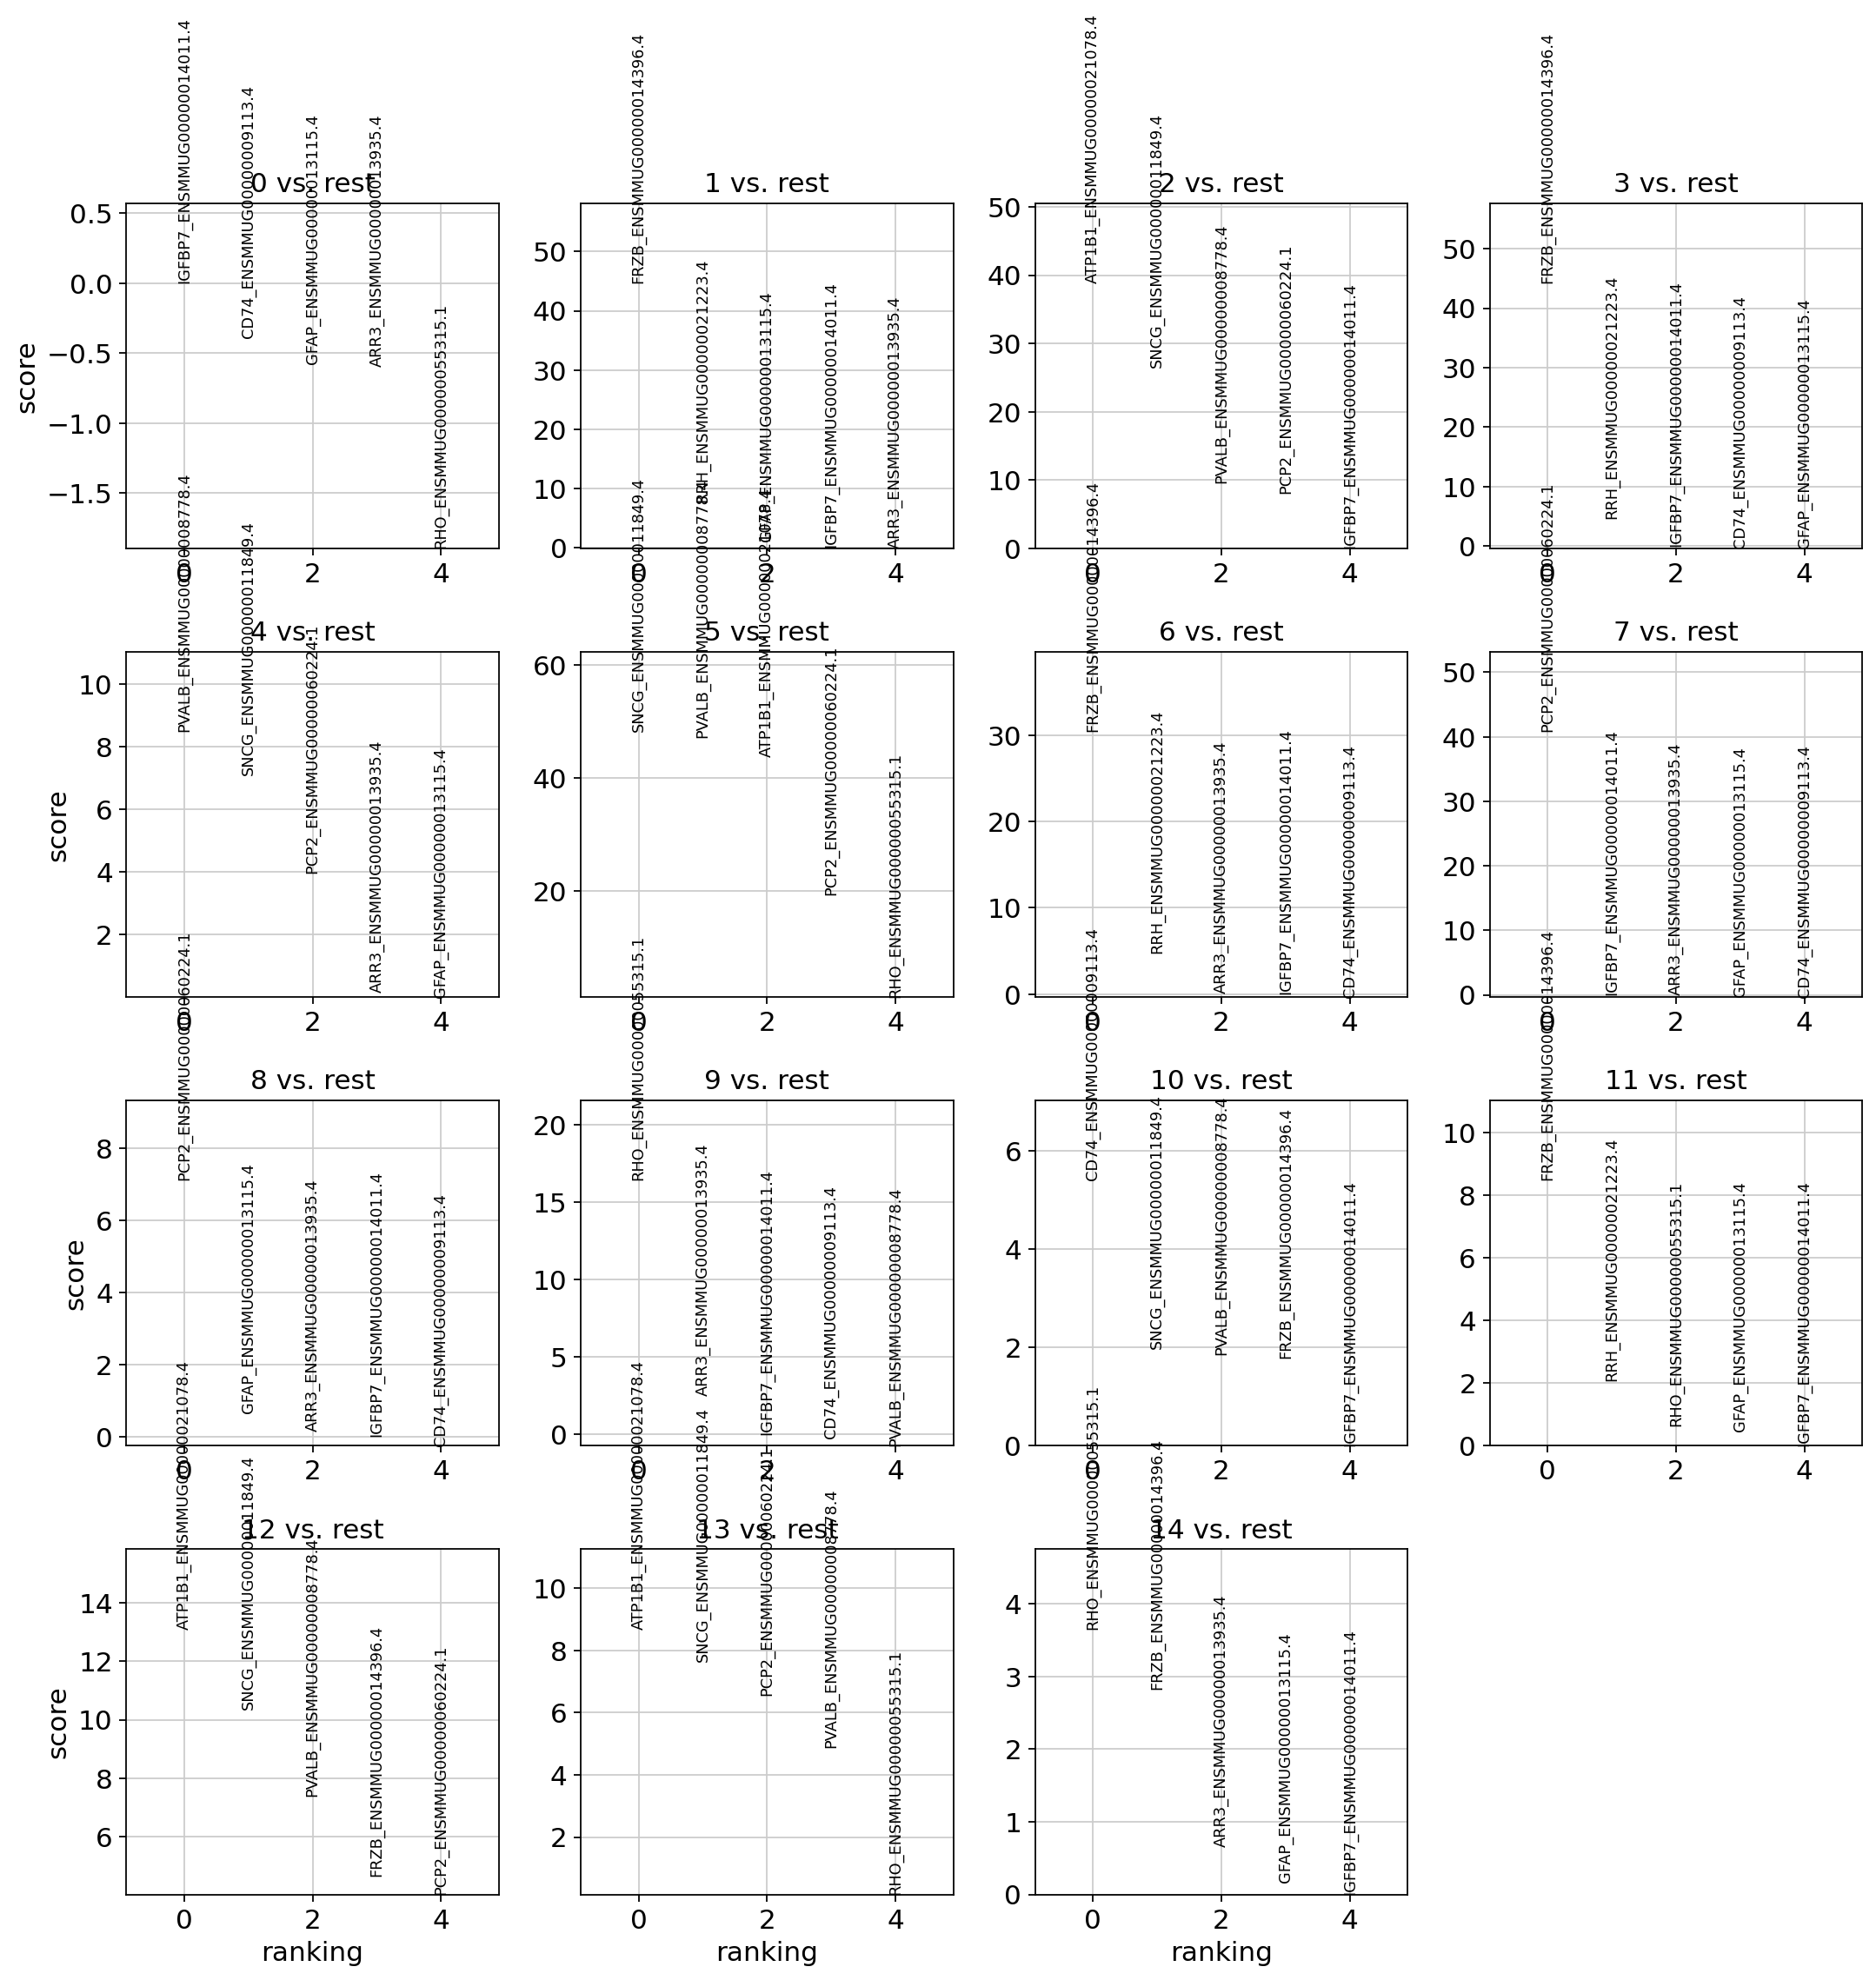

In [ ]:
funcs.rank_marker_genes(adata, marker_genes, marker_gene_dict)

Next, we will use the ranked marker genes to manually define the celltype for each cluster:

In [ ]:
df_leiden = pd.DataFrame()
df_leiden["leiden_cluster"] = np.arange(15)

# Define cluster celltype
df_leiden["celltype"] = [
    "Endothelial cells/\npericytes 1",
    "Müller glia 3",
    "Amacrine cells 2",
    "Müller glia 2",
    "Horizontal cells",
    "Ganglion cells 1",
    "Müller glia 4",
    "Bipolar cells 1",
    "Bipolar cells 2",
    "Rods 1",
    "Microglia",
    "Müller glia 1",
    "Amacrine cells 1",
    "Ganglion cells 2",
    "Rods 2",
]

# Assign a color to each celltype
df_leiden["celltype_colors"] = [
    "cornflowerblue",
    "coral",
    "orchid",
    "orangered",
    "darkblue",
    "darkgreen",
    "moccasin",
    "royalblue",
    "lightskyblue",
    "mediumvioletred",
    "darkorange",
    "crimson",
    "indigo",
    "mediumseagreen",
    "orchid",
]

df_leiden.head()

,leiden_cluster,celltype,celltype_colors
0,0,Endothelial cells/\npericytes 1,cornflowerblue
1,1,Müller glia 3,coral
2,2,Amacrine cells 2,orchid
3,3,Müller glia 2,orangered
4,4,Horizontal cells,darkblue


Create a column in adata.obs to store the celltype for each cell:

In [ ]:
adata.obs["celltype"] = adata.obs.leiden.copy()
adata.rename_categories("celltype", df_leiden["celltype"].values)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Let's check how we did with the celltype assignment by plotting all differentially expressed genes (not just the marker genes) and creating a hierarchical clustering (dendrogram):

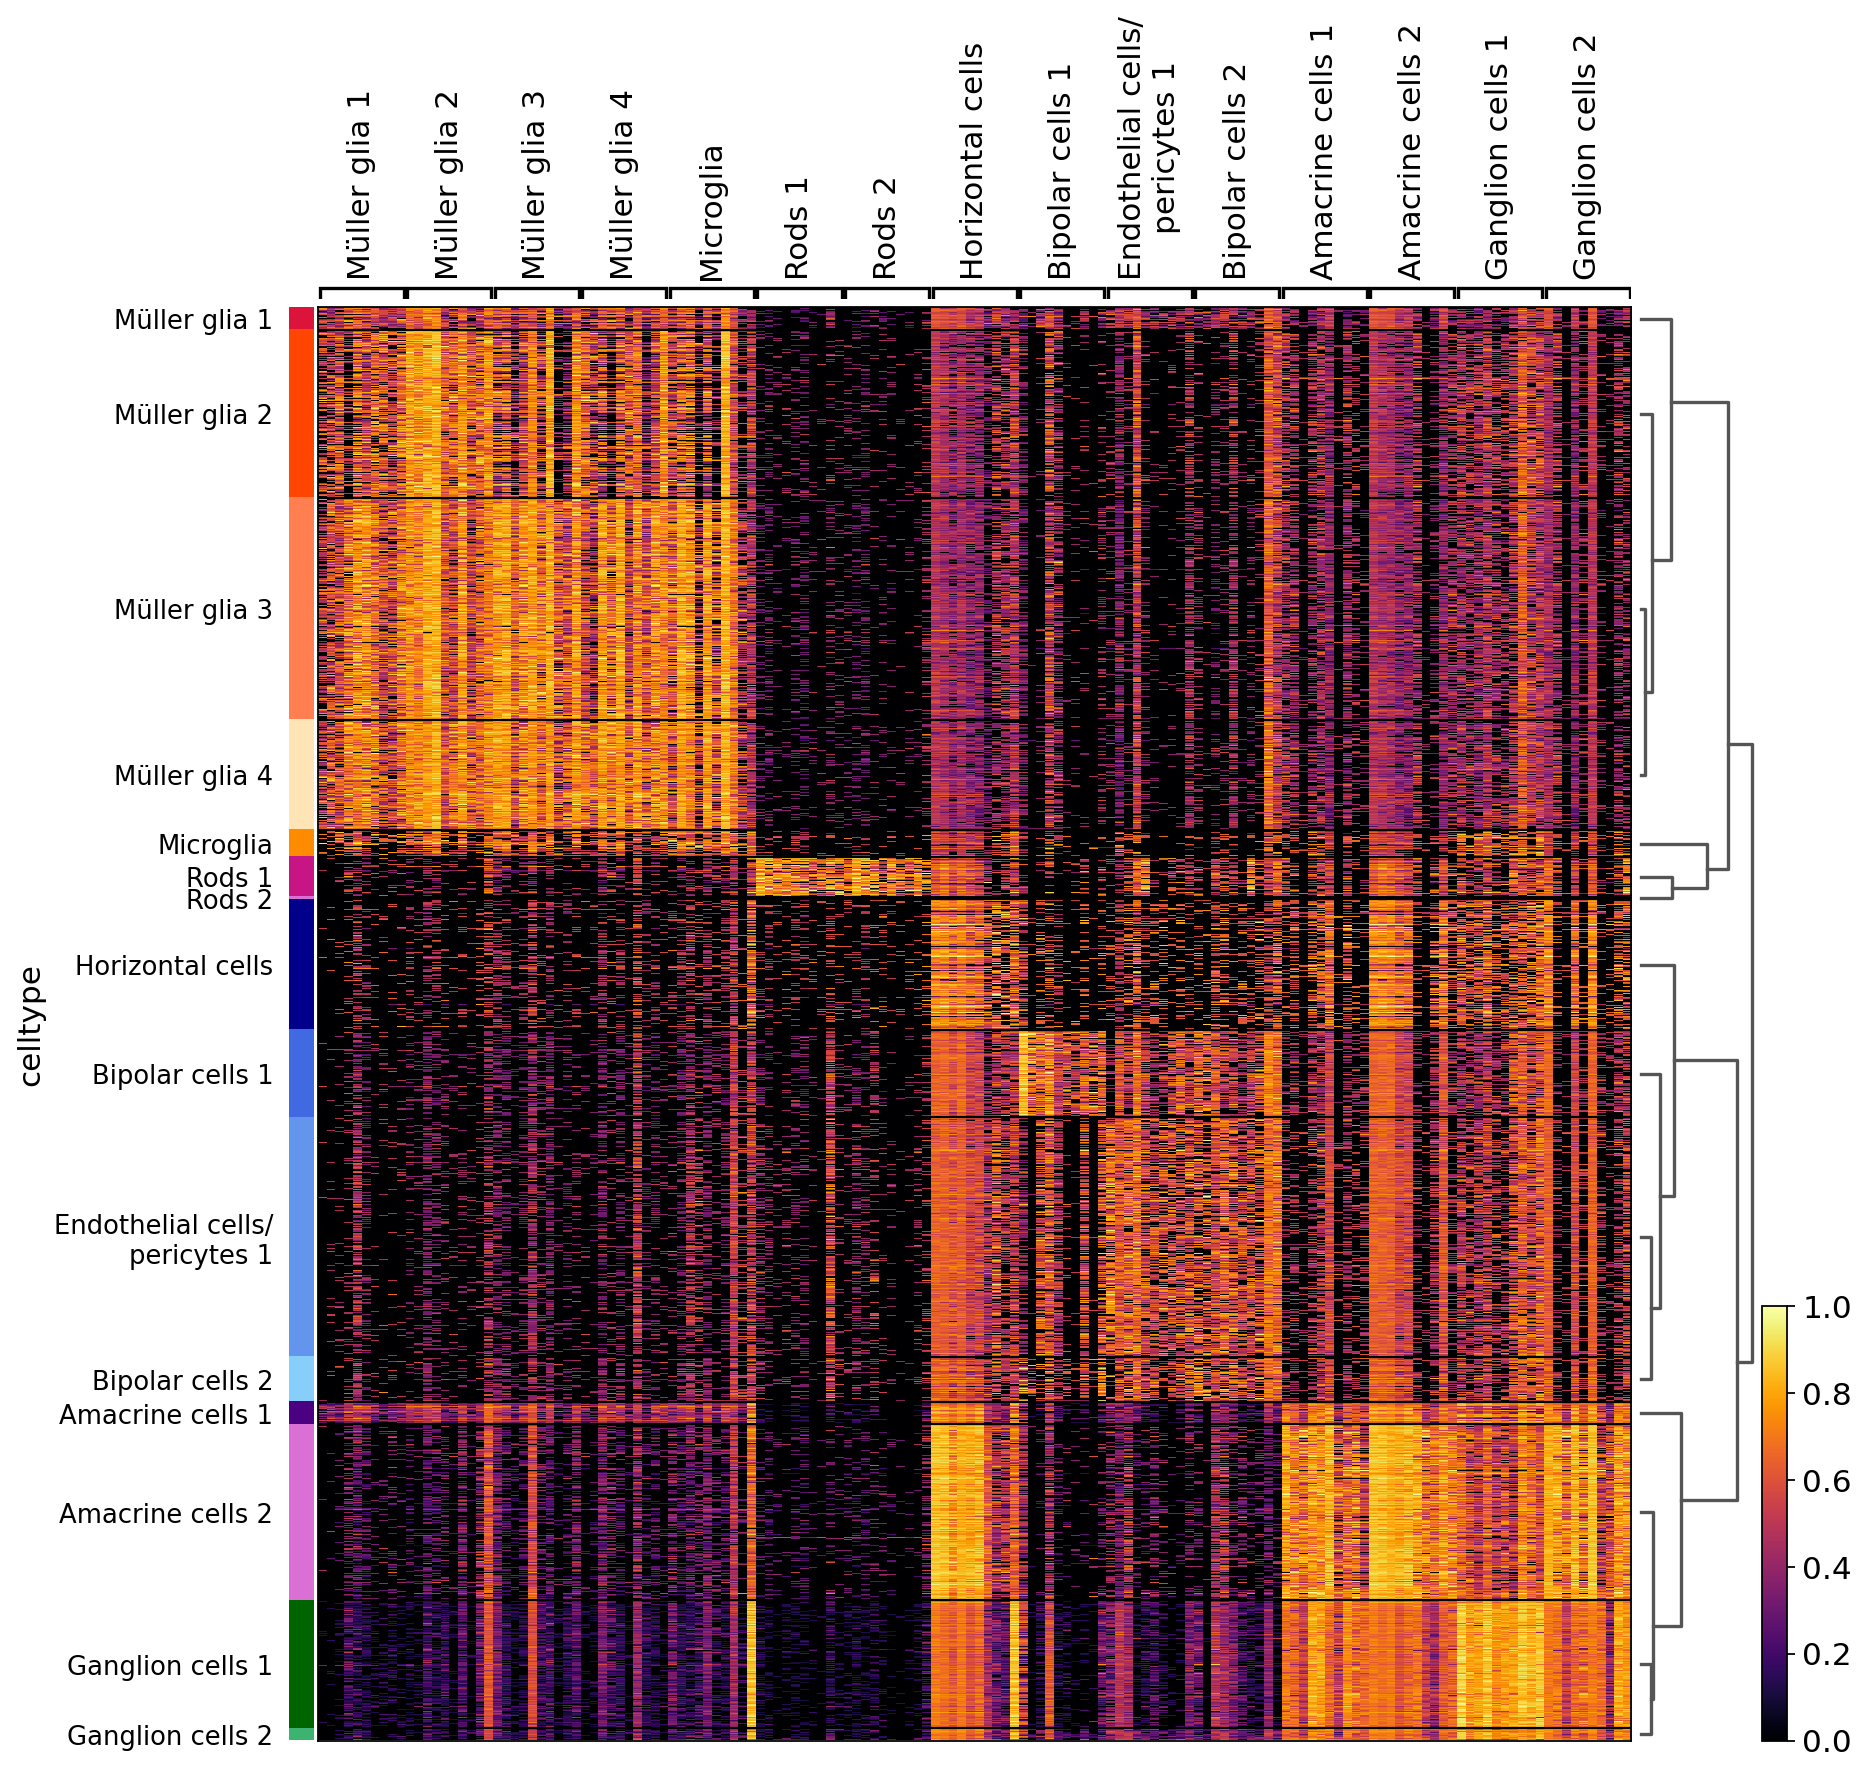

In [ ]:
funcs.celltype_heatmap(adata, df_leiden["celltype_colors"], figsize=(12, 12))

We can see that clusters assigned the same celltype show similar overall expression patterns as expected.

___

# Differentially expressed genes analysis
Below, we will show how `gget` can assist the analysis of differentially expressed (DE) genes as an example downstream analysis. In the celltype assignment above, we found two population of bipolar cells. We will use DE gene analysis to visualize the difference between these clusers.

First, let's find DE genes between the two cell populations. We will compute the fold change and p-value difference for all genes between the defined conditions:

In [ ]:
# Define masks of conditions to compare
control_mask = np.where(adata.obs["celltype"]=="Bipolar cells 1")
experiment_mask = np.where(adata.obs["celltype"]=="Bipolar cells 2")

df_volcano = funcs.volcano_df(adata, control_mask, experiment_mask)
df_volcano.head()

,GeneNames,control,experiment,logFC,p-value
0,_ENSMMUG00000023296.4,0.000000,0.000000,0.000000,NaN
1,U6_ENSMMUG00000036181.3,0.000000,0.000000,0.000000,NaN
2,ZNF692_ENSMMUG00000000634.4,0.058549,0.031487,0.027063,0.172397
3,ZNF672_ENSMMUG00000037875.2,0.003024,0.013586,-0.010562,0.294305
4,SH3BP5L_ENSMMUG00000000632.4,0.096787,0.066643,0.030144,0.253028


Plot volcano plot to visualize the DE genes (significantly DE genes are marked in red):

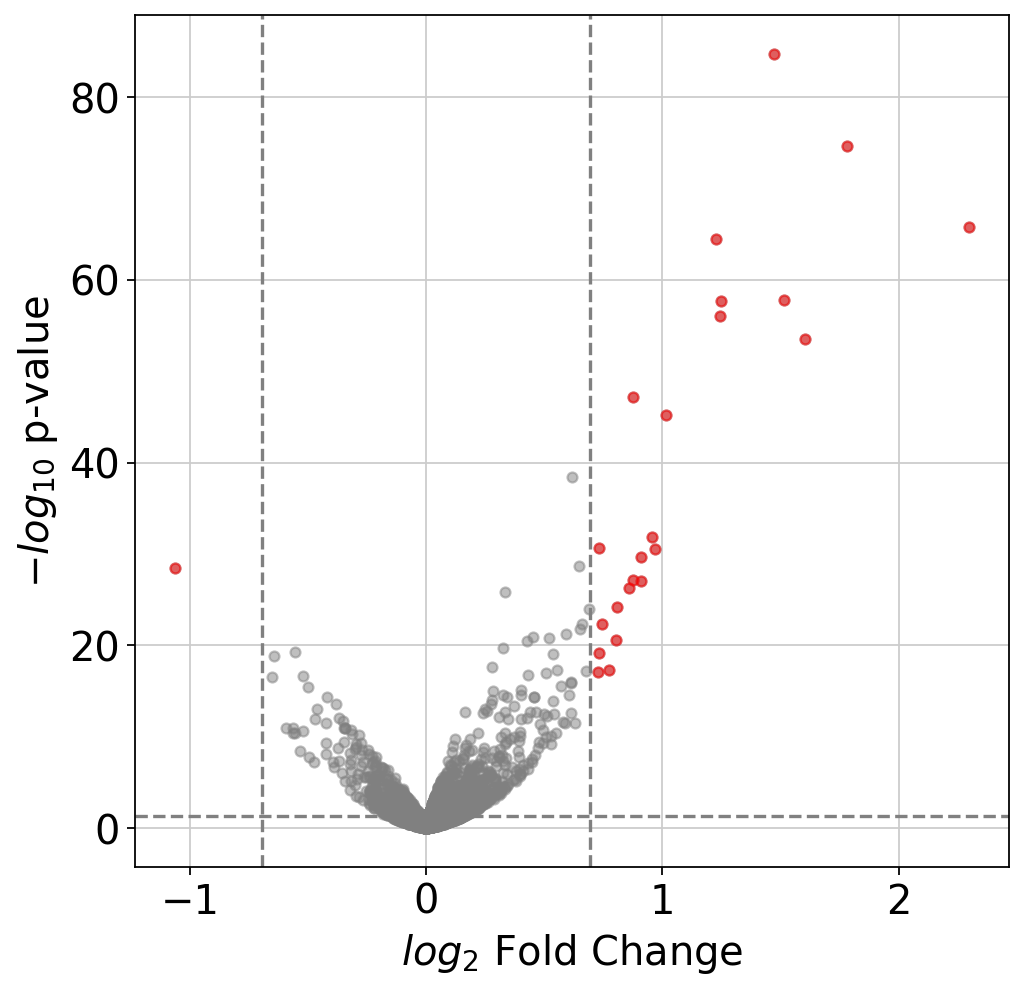

In [ ]:
# Define minimum fold change and p-value alpha for volcano plot thresholds
min_fold_change = 2
alpha = 0.01

funcs.volcano_plot(df_volcano, min_fold_change=min_fold_change, alpha=alpha)

Get a list of genes that were significantly higher expressed in the second population of bipolar cells (these are the genes marked by a red dot to the right on the plot above):

In [ ]:
mask = np.logical_and(df_volcano["logFC"] > np.log(min_fold_change), df_volcano["p-value"] < alpha)
# Sort by fold change
df_de_genes = df_volcano[mask].sort_values("logFC")

# Get the Ensembl ID of all the DE genes
ens_ids = []
for gene in df_de_genes["GeneNames"].values:
    ens_ids.append(gene.split("_")[1])
df_de_genes["EnsemblID"] = ens_ids

# Show first 5 DE genes
df_de_genes.head()

,GeneNames,control,experiment,logFC,p-value,EnsemblID
2136,CYP2J2_ENSMMUG00000015972.4,1.824458,1.097520,0.726937,9.557162e-18,ENSMMUG00000015972.4
9711,PRDM8_ENSMMUG00000051357.1,0.988058,0.255780,0.732278,2.310368e-31,ENSMMUG00000051357.1
15299,_ENSMMUG00000054106.1,1.773402,1.040951,0.732451,6.638133e-20,ENSMMUG00000054106.1
5631,_ENSMMUG00000053116.1,1.253115,0.508457,0.744658,4.973337e-23,ENSMMUG00000053116.1
4544,_ENSMMUG00000021246.4,2.128292,1.353531,0.774762,5.712902e-18,ENSMMUG00000021246.4


# `gget.info` to fetch information about genes
We can see that some of the DE genes are not annotated with a gene name. Let's use gget.info to get the names and description (if available on the Ensembl database) for all DE genes:

In [ ]:
info_dict = gget.info(df_de_genes["EnsemblID"])
info_dict

{'ENSMMUG00000004064': {'assembly_name': 'Mmul_10',
  'biotype': 'protein_coding',
  'canonical_transcript': 'ENSMMUT00000039028.3',
  'description': 'ATPase H+ transporting V1 subunit H [Source:VGNC Symbol;Acc:VGNC:70094]',
  'display_name': 'ATP6V1H',
  'end': 54510520,
  'id': 'ENSMMUG00000004064',
  'object_type': 'Gene',
  'seq_region_name': '8',
  'species': 'macaca_mulatta',
  'start': 54353801,
  'strand': -1},
 'ENSMMUG00000004771': {'assembly_name': 'Mmul_10',
  'biotype': 'protein_coding',
  'canonical_transcript': 'ENSMMUT00000006739.4',
  'description': 'C-X-C motif chemokine ligand 14 [Source:VGNC Symbol;Acc:VGNC:71394]',
  'display_name': 'CXCL14',
  'end': 133040462,
  'id': 'ENSMMUG00000004771',
  'object_type': 'Gene',
  'seq_region_name': '6',
  'species': 'macaca_mulatta',
  'start': 133031619,
  'strand': -1},
 'ENSMMUG00000005023': {'assembly_name': 'Mmul_10',
  'biotype': 'protein_coding',
  'canonical_transcript': 'ENSMMUT00000099485.1',
  'description': 'coiled

That's a lot of information in one dictionary. Let's start with one of the Ensembl IDs that was not annotated, e.g. ENSMMUG00000021246:

In [ ]:
info_dict["ENSMMUG00000021246"]

{'assembly_name': 'Mmul_10',
 'biotype': 'protein_coding',
 'canonical_transcript': 'ENSMMUT00000029894.4',
 'end': 98755023,
 'id': 'ENSMMUG00000021246',
 'object_type': 'Gene',
 'seq_region_name': '2',
 'species': 'macaca_mulatta',
 'start': 98646979,
 'strand': -1}

# `gget.seq` and `gget.blast` to find missing gene annotation

The Ensembl database does not contain a name or description for this gene either. However, we can see that the ID belongs to a protein coding gene (see 'biotype'). Maybe a BLAST search will tell us more. Let's use a combination of gget.seq and gget.blast to get the nucleotide sequence of this gene and BLAST it:

In [ ]:
# BLAST the first 500 nucleotides of ID ENSMMUG00000021246
blast_results = gget.blast(gget.seq("ENSMMUG00000021246")[1][:500])
funcs.pretty_print(blast_results.head(), ["Description"])

25 Apr 2022 18:23:00 INFO Requesting nucleotide sequence of ENSMMUG00000021246 from Ensembl.
25 Apr 2022 18:23:00 INFO Sequence recognized as nucleotide sequence.
25 Apr 2022 18:23:00 INFO BLAST will use program 'blastn' with database 'nt'.
25 Apr 2022 18:23:03 INFO BLAST initiated with search ID 6DTS7H96013. Estimated time to completion: 30 seconds.
25 Apr 2022 18:23:35 INFO Retrieving results...
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"MACACA MULATTA BAC cloneCH250-293L3 from chromosome 2,complete sequence",Macaca mulatta,Rhesus monkey,9544,924.0,924.0,100%,0.000000e+00,100.00%,185684,AC198108.4
1,"PREDICTED: Macaca fascicularisHIG1 hypoxia inducible domainfamily member 1A (HIGD1A),transcript variant X3, mRNA",Macaca fascicularis,crab-eating macaque,9541,874.0,874.0,100%,0.000000e+00,98.20%,1886,XM_045386419.1
2,"PREDICTED: Macaca fascicularisprotein MIX23-like(LOC123571841), misc_RNA",Macaca fascicularis,crab-eating macaque,9541,874.0,874.0,100%,0.000000e+00,98.20%,3936,XR_006696116.1
3,Rhesus Macaque BACCH250-455N24 () completesequence,Macaca mulatta,Rhesus monkey,9544,874.0,874.0,100%,0.000000e+00,98.20%,175273,AC196812.6
4,"PREDICTED: Macaca fascicularisHIG1 hypoxia inducible domainfamily member 1A (HIGD1A),transcript variant X2, mRNA",Macaca fascicularis,crab-eating macaque,9541,619.0,619.0,71%,9.000000e-173,97.78%,1661,XM_005546793.3


The BLAST hits suggest that this gene might be HIG1 hypoxia inducible domain family member 1A (HIGD1A).



___

# `gget.blast` to confirm existing gene annotation

Let's take a look at another DE gene, CCDC136_ENSMMUG00000009625.4. Unlike the previous gene, this gene is annotated with gene name CCDC136. Let's BLAST it:

In [ ]:
blast_results = gget.blast(gget.seq("ENSMMUG00000009625")[1][:500])
funcs.pretty_print(blast_results.head(), ["Description"])

25 Apr 2022 18:31:49 INFO Requesting nucleotide sequence of ENSMMUG00000009625 from Ensembl.
25 Apr 2022 18:31:49 INFO Sequence recognized as nucleotide sequence.
25 Apr 2022 18:31:49 INFO BLAST will use program 'blastn' with database 'nt'.
25 Apr 2022 18:31:49 INFO BLAST initiated with search ID 6DU8NRHM016. Estimated time to completion: 30 seconds.
25 Apr 2022 18:32:22 INFO Retrieving results...
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"Pan troglodytes BAC cloneCH251-587P5 from chromosome 7,complete sequence",Pan troglodytes,chimpanzee,9598,802,802,100%,0.000000e+00,95.60%,201552,AC192999.3
1,"Homo sapiens chromosome 7clone RP11-66F23, completesequence",Homo sapiens,human,9606,791,791,100%,0.000000e+00,95.20%,182426,AC024952.4
2,"PREDICTED: Cercocebus atysopsin 1 (cone pigments),short-wave-sensitive (OPN1SW),transcript variant X1, mRNA",Cercocebus atys,sooty mangabey,9531,322,322,35%,3.000000e-83,99.44%,3367,XM_012087992.1
3,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X8, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,1848,XM_015134871.2
4,"PREDICTED: Macaca mulattacoiled-coil domain containing136 (CCDC136), transcriptvariant X7, mRNA",Macaca mulatta,Rhesus monkey,9544,248,248,26%,5.000000e-61,100.00%,2722,XM_028846261.1


It looks like the BLAST suggest the gene also aligns to a prediction for OPN1SW, which encodes short wave sensitive cone pigments. It is unclear which annotation is correct (CCDC136 or OPN1SW?), but this is important to know about a gene of interest.
___

# `gget.blat` to assess genome locations of DE genes

Sometimes genes may be up-/down-regulated due to proximity to another up-/down-regulated gene. Let's combine gget.seq and gget.blat to quickly get the chromosome locations of all DE genes. Since no mucaca genomes are available for BLAT, we will use the default human genome:

In [ ]:
df_list = []

for id in df_de_genes["EnsemblID"].values:
    # Use gget.seq to get the nucleotide sequence
    seq = gget.seq(id)

    # Only keep the first (best) result for each sequence
    df_list.append(gget.blat(seq[1]).head(1))

# Concatenate the result data frames    
df_blat = pd.concat(df_list)
df_blat = df_blat.reset_index(drop=True)
# Add gene names and logFC to BLAT results data frame
df_blat["gene"] = ens_ids
df_blat["logFC"] = df_de_genes["logFC"].values

25 Apr 2022 18:24:37 INFO Requesting nucleotide sequence of ENSMMUG00000015972 from Ensembl.
25 Apr 2022 18:24:37 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
25 Apr 2022 18:24:37 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
25 Apr 2022 18:24:41 INFO Requesting nucleotide sequence of ENSMMUG00000051357 from Ensembl.
25 Apr 2022 18:24:41 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
25 Apr 2022 18:24:41 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
25 Apr 2022 18:24:43 INFO Requesting nucleotide sequence of ENSMMUG00000054106 from Ensembl.
25 Apr 2022 18:24:43 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
25 Apr 2022 18:24:43 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
25 Apr 2022 18:24:45 INFO Requesting nucleotide sequence of ENSMMUG00000053116 fro

In [ ]:
df_blat

,genome,query_size,aligned_start,aligned_end,matches,mismatches,%_aligned,%_matched,chromosome,strand,start,end,gene,logFC
0,hg38,8000,39,8000,7330,427,99.52,92.06,chr1,-,59918571,59926784,ENSMMUG00000015972.4,0.726937
1,hg38,8000,8,8000,7432,394,99.91,92.98,chr4,+,80183853,80191788,ENSMMUG00000051357.1,0.732278
2,hg38,8000,1,8000,7589,348,100.00,94.86,chr8,+,64373309,64381298,ENSMMUG00000054106.1,0.732451
3,hg38,8000,1,8000,7430,287,100.00,92.88,chr7,+,94656370,94664403,ENSMMUG00000053116.1,0.744658
4,hg38,8000,1,7959,6809,372,99.49,85.55,chr3,-,42794545,42804512,ENSMMUG00000021246.4,0.774762
5,hg38,6396,1,6396,6015,311,100.00,94.04,chr12,+,6840936,6847390,ENSMMUG00000005190.4,0.805701
6,hg38,8000,1,8000,7511,354,100.00,93.89,chr5,-,84376503,84384880,ENSMMUG00000007661.4,0.806820
7,hg38,8000,1,8000,7164,527,100.00,89.55,chr15_KN538374v1_fix,-,3320867,3334271,ENSMMUG00000009430.4,0.856603
8,hg38,3784,1,3784,3480,220,100.00,91.97,chr11,+,84972951,84976703,ENSMMUG00000051202.1,0.873754
9,hg38,8000,2,7369,5677,552,92.10,77.05,chr16,+,56625770,56637608,ENSMMUG00000054142.1,0.874762


Check how the DE genes are distributed throughout the genome:

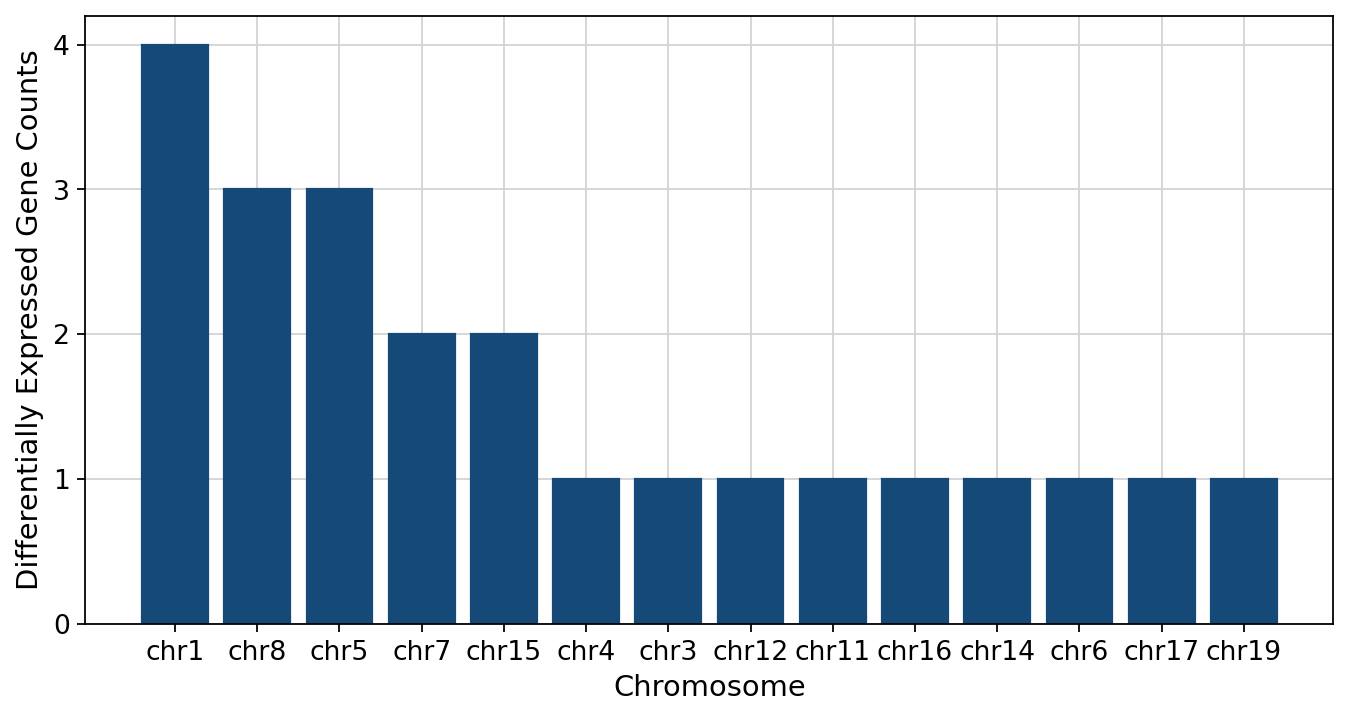

In [ ]:
# Replace long chromosome names
chrs = []
for chr in df_blat["chromosome"].values:
    chrs.append(chr.split("_")[0])
df_blat["chromosome"] = chrs

# Plot gene counts per chromosome 
funcs.chr_locations(df_blat)

___

# Isoform analysis with `gget.info`, `gget.seq` and `gget.muscle`

Expand info to get the names of all known isoforms:

In [ ]:
gget.info("ENSMMUG00000009625", expand=True)

{'ENSMMUG00000009625': {'Transcript': [{'biotype': 'protein_coding',
    'display_name': 'CCDC136-201',
    'id': 'ENSMMUT00000041838'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-209',
    'id': 'ENSMMUT00000094799'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-208',
    'id': 'ENSMMUT00000086187'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-207',
    'id': 'ENSMMUT00000013452'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-206',
    'id': 'ENSMMUT00000081345'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-205',
    'id': 'ENSMMUT00000092110'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-204',
    'id': 'ENSMMUT00000013450'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-203',
    'id': 'ENSMMUT00000013440'},
   {'biotype': 'protein_coding',
    'display_name': 'CCDC136-202',
    'id': 'ENSMMUT00000096620'},
   {'biotype': 'protein_coding',
    'display_name': 'C

We can use `seqtype="transcript"` and `isoforms=True` with `gget.seq` to get the amino acid sequences of all known transcripts from our gene ID:

In [ ]:
gget.seq("ENSMMUG00000009625", isoforms=True, seqtype="transcript", save=True)

25 Apr 2022 18:25:40 INFO Requesting amino acid sequences of all transcripts of gene ENSMMUG00000009625 from UniProt.


['>ENSMMUT00000041838 uniprot_id: F7H6P6 ensembl_id: ENSMMUT00000041838 gene_name(s): CCDC136 organism: Macaca mulatta (Rhesus macaque) sequence_length: 721',
 'MEAGAGAGAGAAGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEEEEVEEEEEQVQKGGSVGSLSVNKHRGLSLTETELEELRAQVLQLVAELEETRELAGQHEDDSLELQGLLEDERLASAQQAEVFTKQIQQLQGELRSLREEISLLEHEKESELKEIERELHLAQAEIQSLRQAAEDSATEHESDIASLQEDLCRMQNELEDMERIRGDYEMEIASLRAEMEMKSSEPSSSLGLSDYSGLQEELQELRERYHFLNEEYRALQESNSSLTGQLADLESERTQRATERWLESQTLSMTSAESQTSEMDFLEPDPEMQLLRQQLRDAEEQMHGMKNKCQELCCELEELQHHRQVSEEEQRRLQRELKCAQNEVLRFQTSHSVTQHFEEMVAKVLIKLQAVQAMYQISQEEHSQLQEQMEKLLAKQKDLKEELDACEREFKECMECLEKPVAPQNDKNEIKELQTKLRELQLQYQASMDEQGRLLVVQEQLEGQLQCCQEELRQLREKRPSVVKEARGKNANKNMNKNANGVKMKKVIKPCSDTSESDFETRKSLEVVLYYKASQRKLDGLAKEEEKKEEMKEEKKEEVKEEAKEQCGDELVAEPADPGEAKSTEDQEENEEDKEQEEKEEDSEEEEDDIDSSLESPEENNPLRLSESKKSSPTPDPPIFSLPLVGLVVISALLWCWWAETSS',
 '>ENSMMUT00000094799 uniprot_id: A0A5F7ZA03 ensembl_id: ENSMMUT00000094799 gene_name(s): CCDC136 organism: Macaca 

How do these isoforms differ from each other? Let's align them!

In [ ]:
gget.muscle("seq_results.fa")

25 Apr 2022 18:25:42 INFO MUSCLE compiled. 
25 Apr 2022 18:25:42 INFO MUSCLE aligning... 

muscle 5.2.linux64 [00617b]  13.3Gb RAM, 2 cores
Built Apr 13 2022 00:43:46
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 10 seqs, avg length 858, max 1208

00:00 38Mb   CPU has 2 cores, running 2 threads
00:04 197Mb   100.0% Calc posteriors
00:04 197Mb   100.0% Consistency (1/2)
00:04 197Mb   100.0% Consistency (2/2)
00:04 197Mb   100.0% UPGMA5
00:04 197Mb   100.0% Refining
25 Apr 2022 18:25:46 INFO MUSCLE alignment complete. Alignment time: 4.22 seconds




ENSMMUT00000081345 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013452 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000096620 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013440 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000041838 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013454 MSPSLHPSPQPVPHPPALPFSV-LSGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000092110 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013450 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000086187 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000094799 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEE